# SMS Classification of Recipes using DistilBERT 

## 0. Introduction

In this notebook, we fine-tune and evaluate the pretrained [DistilBert](https://arxiv.org/abs/1910.01108) model on the sms.csv dataset 

We implement Simple Transformer's [binary classifier](https://github.com/ThilinaRajapakse/simpletransformers) that uses [Hugging Face's PyTorch implementation](https://github.com/huggingface/transformers/tree/master/src/transformers/models/distilbert) based Google's [BERT](https://github.com/google-research/bert).

The goals of this notebook are:
1. Analyze the dataset  
2. Perform transfer learning using the dataset to finetune larger pretrained language models
3. Discuss results and further opportunities for research

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
from sklearn.model_selection import StratifiedKFold
import ast
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re

In [2]:
!nvidia-smi

Thu Apr 28 20:46:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P2    56W / 200W |   2673MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1 Importing the data
Our first steps will be importing the data and doing initial preprocessing
We are looking for how the columns are laid out, if there are any missing values and how
the data is distributed

In [3]:
data_dir = './'
path = Path(data_dir)

In [4]:
text_file = Path(data_dir, 'sms.csv')

In [5]:
df = pd.read_csv(text_file, names=['label', 'text_messages'], header=None) 
print("Shape of data=>",df.shape)
#preliminary data loading and analysis

Shape of data=> (5572, 2)


In [6]:
df.dtypes, [type(cell) for cell in df.iloc[0]]

(label            object
 text_messages    object
 dtype: object,
 [str, str])

In [7]:
df.text_messages = df.text_messages.str.split(',')

In [8]:
# df['text_messages'] = df['text_messages'].apply(ast.literal_eval)

In [9]:
df['text_messages_str'] = df['text_messages'].apply(lambda x: '. '.join(x))
df['text_messages_test'] = df['text_messages'].apply(lambda x: '. '.join(x))

In [10]:
df['text_messages_str'][0]

'Go until jurong point.  crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [11]:
df['text_messages_test'].head()

0    Go until jurong point.  crazy.. Available only...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf.  he lives ar...
Name: text_messages_test, dtype: object

In [12]:
df.isnull().values.any()

False

### 1.1 Preparing the Data for Plotting and Baseline Models
Our next couple steps involve creating new dataframe columns 
removing stopwords and punctuation and plotting the most frequent 
and least frequent words to see if they give us any intuitions about the 
data. 

In [13]:
stop = list(stopwords.words('english'))

In [14]:
df['text_messages_str'] = df['text_messages_str'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [15]:
df['text_messages_str'] = df['text_messages_str'].str.replace(r'[^a-zA-Z\s]+', '').replace(r'\s+', ' ')

C:\Users\Abdul\AppData\Local\Temp/ipykernel_16220/4259489594.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_messages_str'] = df['text_messages_str'].str.replace(r'[^a-zA-Z\s]+', '').replace(r'\s+', ' ')


In [16]:
df['text_messages_test'].head()

0    Go until jurong point.  crazy.. Available only...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf.  he lives ar...
Name: text_messages_test, dtype: object

### 1.2 Plotting our initial observations
Below we can see the most common words in this text messaging dataset

Text(0, 0.5, 'Word')

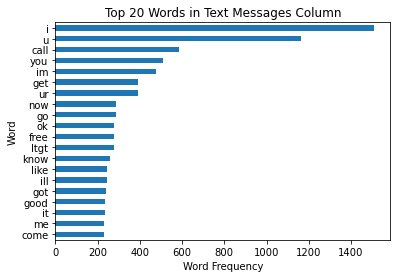

In [17]:
wf_big = pd.Series(' '.join(df['text_messages_str']).lower().split()).value_counts()[:20].sort_values().plot(kind = 'barh',title='Top 20 Words in Text Messages Column')
wf_big.set_xlabel("Word Frequency")
wf_big.set_ylabel("Word")

Text(0, 0.5, 'Word')

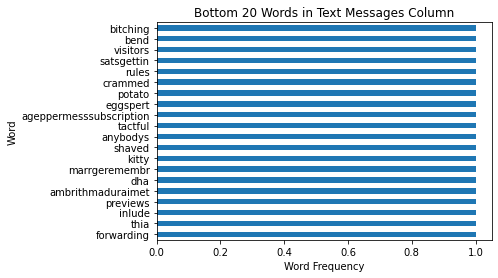

In [18]:
wf_big3 = pd.Series(' '.join(df['text_messages_str']).lower().split()).value_counts()[-20:].sort_values().plot(kind = 'barh',title='Bottom 20 Words in Text Messages Column')
wf_big3.set_xlabel("Word Frequency")
wf_big3.set_ylabel("Word")

In [19]:
df['text_messages'].iloc[10]

["I'm gonna be home soon and i don't want to talk about this stuff anymore tonight",
 " k? I've cried enough today."]

In [20]:
sms = df[['text_messages_test', 'label']]

In [21]:
sms.iloc[50]

text_messages_test    What you thinked about me. First time you saw ...
label                                                               ham
Name: 50, dtype: object

In [22]:
 #sms.shape,sms.drop_duplicates(subset='text_messages').shape

In [23]:
sms.head()

,text_messages_test,label
0,Go until jurong point. crazy.. Available only...,ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,Nah I don't think he goes to usf. he lives ar...,ham


In [24]:
sms_cleaned_csv = 'clean_sms_df.csv'
train_path = Path(data_dir, sms_cleaned_csv)

In [25]:
sms.to_csv(train_path, index=False)

Below I'm checking for the distribution of sequence length by a count of words split on whitespace
Many transformer models have a fixed sequence that's required, such as BERT which is 512 
And since we will be finetuning a transformer model below, this is a necessary step
I check to see how many of the concatenated method/ingredients rows are over 500
And since there aren't many I drop those for the sake of being able to use a variety of models

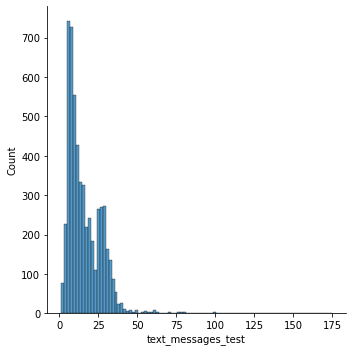

In [26]:
sns.displot(sms['text_messages_test'].apply(lambda x: len(x.split(' '))), height=5)

In [27]:
sms.head()

,text_messages_test,label
0,Go until jurong point. crazy.. Available only...,ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,Nah I don't think he goes to usf. he lives ar...,ham


In [28]:
d = {'spam': True, 'ham': False}

In [29]:
sms['label'] = sms['label'].map(d)

C:\Users\Abdul\AppData\Local\Temp/ipykernel_16220/4167094092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sms['label'] = sms['label'].map(d)


In [30]:
sms.head()

,text_messages_test,label
0,Go until jurong point. crazy.. Available only...,False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,U dun say so early hor... U c already then say...,False
4,Nah I don't think he goes to usf. he lives ar...,False


In [31]:
sms['label'] = sms['label'].astype(int) #here I'm turning the true and false values into 0 and 1's since BERT and similar models require labels in this format

C:\Users\Abdul\AppData\Local\Temp/ipykernel_16220/2202863092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sms['label'] = sms['label'].astype(int) #here I'm turning the true and false values into 0 and 1's since BERT and similar models require labels in this format


In [32]:
sms.label.value_counts() #0 representing ham and 1 representing spam

0    4825
1     747
Name: label, dtype: int64

## 2. Train and Evaluate Baseline Models
Below we will be using various Naive Bayes models as a baseline for classification, one of the benefits of which is fast training time
We will use TF-IDF to turn our text messages column into a vectored representation
TF-IDF shows the rarity of a word in our dataset. If a word is rare then in theory this word is particularly helpful in determining if a text is spam or not.
We will be using K-fold Cross Validation which I will explain in further detail below


In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_predict
def make_pipe_from_classifier(classifier_name, classifier):
    ''' assuming every classifier of interest will take tf-idf as input'''
    return Pipeline([('tf-idf', TfidfVectorizer()), (classifier_name, classifier())])

#First baseline model we will explore is Naive Bayes, will be using Bernoulli since it works best for binary classification
bernoulli_pipe = make_pipe_from_classifier('BNB', BernoulliNB)

#The next baseline model we will be looking at is Logistic regression
log_regression_pipe = make_pipe_from_classifier('L_R', LogisticRegression)

svm_pipe = make_pipe_from_classifier('SVM', svm.SVC)


pipe_cvpreds_dict = dict()
for ppipe in [bernoulli_pipe, log_regression_pipe, svm_pipe]:
    pipe_cvpreds_dict[ppipe.steps[1][0]]  = cross_val_predict(ppipe, X=sms['text_messages_test'], y=sms['label'], cv=skf.split(X=sms['text_messages_test'], y=sms['label']))


In [34]:
for classifier, preds in pipe_cvpreds_dict.items():
    print(f'_____________{classifier} 5-fold predictions_________')
    print(classification_report(sms['label'], preds, digits=3))

_____________BNB 5-fold predictions_________
              precision    recall  f1-score   support

           0      0.975     1.000     0.987      4825
           1      0.997     0.837     0.910       747

    accuracy                          0.978      5572
   macro avg      0.986     0.918     0.949      5572
weighted avg      0.978     0.978     0.977      5572

_____________L_R 5-fold predictions_________
              precision    recall  f1-score   support

           0      0.969     0.999     0.984      4825
           1      0.988     0.794     0.880       747

    accuracy                          0.971      5572
   macro avg      0.979     0.896     0.932      5572
weighted avg      0.972     0.971     0.970      5572

_____________SVM 5-fold predictions_________
              precision    recall  f1-score   support

           0      0.981     1.000     0.990      4825
           1      0.997     0.877     0.933       747

    accuracy                          0.983    

 As you can see these simple models perform very well and train quickly
 We will be moving to our main approach which is using transformers and transfer learning to finetune a large language model
 The language model we will be working on will be DistilBERT

 For our train/validation split we will be doing K-fold cross validation and a small grid search to find the optimal time for training epochs

In [35]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

##  Why Kfold?  The dataset is small so it's  more affordable.
When the dataset is small taking a random 20% for testing is a gamble that that 20% is representative of the data.
In this case we think it is better to use all of data as test and aggregate results.

## 3.  Finetune our main model
Below we will use transfer learning to finetune our large pre-trained language models DistilBert

In [36]:
cuda_available = torch.cuda.is_available()
skf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

epoch2mcc = dict()
for i in [1,2]:
    results = []
    # Create a TransformerModel
    model_args = ClassificationArgs()
    model_args.num_train_epochs = i
    model_args.overwrite_output_dir = True
    model_args.evaluate_during_training = True
    model_args.use_cuda = cuda_available
    model_args.do_lower_case = True
    model_args.use_cached_eval_features = True
    model_args.verbose = False
    model_args.cache_dir = 'cache_dir'
    for train_inds, test_inds in notebook.tqdm(skf.split(sms['text_messages_test'], sms['label'])):
        train_df = sms.iloc[train_inds]
        test_df = sms.iloc[test_inds]
#         print(train_df.head())
        # Train the model
        model = ClassificationModel('distilbert', 'distilbert-base-uncased', args=model_args)
        model.train_model(train_df, eval_df=test_df, output_dir=f'./outputs/train_epochs_{i}')
        # Evaluate the model
        result, model_outputs, wrong_predictions = model.eval_model(test_df)
        results.append(result['mcc'])
    epoch2mcc[i] = np.array(results)

0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:585: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4457 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1115 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.969188255613126, 'tp': 146, 'tn': 961, 'fp': 4, 'fn': 4, 'auroc': 0.9979412780656304, 'auprc': 0.9923011438648845, 'eval_loss': 0.03188110554515983}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/4457 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9806956083477508, 'tp': 147, 'tn': 963, 'fp': 2, 'fn': 3, 'auroc': 0.9998203799654577, 'auprc': 0.9988913786968058, 'eval_loss': 0.020332122700554983}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/4458 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9806452170382683, 'tp': 146, 'tn': 964, 'fp': 1, 'fn': 4, 'auroc': 0.9998549222797928, 'auprc': 0.9990435184551926, 'eval_loss': 0.021540635114901566}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/4458 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9806452170382683, 'tp': 146, 'tn': 964, 'fp': 1, 'fn': 4, 'auroc': 0.9996856649395509, 'auprc': 0.9982509178057734, 'eval_loss': 0.019414317182132174}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/4458 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9768911917098445, 'tp': 147, 'tn': 962, 'fp': 3, 'fn': 3, 'auroc': 0.9990777202072538, 'auprc': 0.995363044516616, 'eval_loss': 0.02575964317407592}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

  0%|          | 0/4457 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Epoch 1 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9767465778887531, 'tp': 145, 'tn': 964, 'fp': 1, 'fn': 5, 'auroc': 0.9986563039723662, 'auprc': 0.9931507717938958, 'eval_loss': 0.033420264650028134}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

  0%|          | 0/4457 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Epoch 1 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9922832211811169, 'tp': 148, 'tn': 965, 'fp': 0, 'fn': 2, 'auroc': 0.999986183074266, 'auprc': 0.9999114054451803, 'eval_loss': 0.007816193749437974}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/4458 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Epoch 1 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9884142906278496, 'tp': 147, 'tn': 965, 'fp': 0, 'fn': 3, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.007912221160638312}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Di

  0%|          | 0/4458 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Epoch 1 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9922832211811169, 'tp': 148, 'tn': 965, 'fp': 0, 'fn': 2, 'auroc': 0.9999654576856649, 'auprc': 0.9997809808250011, 'eval_loss': 0.00982959220813687}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/4458 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir\cached_train_distilbert_128_2_2
C:\Users\Abdul\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Epoch 1 of 2:   0%|          | 0/558 [00:00<?, ?it/s]

C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Abdul\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir\cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/140 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9884203485781047, 'tp': 148, 'tn': 964, 'fp': 1, 'fn': 2, 'auroc': 0.999972366148532, 'auprc': 0.9998239804810041, 'eval_loss': 0.008538832479929884}


# 4. Results from our main model 


In [37]:
epoch2mcc

{1: array([0.96918826, 0.98069561, 0.98064522, 0.98064522, 0.97689119]),
 2: array([0.97674658, 0.99228322, 0.98841429, 0.99228322, 0.98842035])}

In [38]:
result

{'mcc': 0.9884203485781047,
 'tp': 148,
 'tn': 964,
 'fp': 1,
 'fn': 2,
 'auroc': 0.999972366148532,
 'auprc': 0.9998239804810041,
 'eval_loss': 0.008538832479929884}

As you can see the results above while being very good took some time to achieve compared to the simpler models. I think this is an example of gauging the scope of your problem and trying to use the most efficient model that trains quickly but also has good results